# WHOLE experimentation


## Loading data and dependencies

###  Load the necessary packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import *
import torch
import torch.optim as optim

from fastai import *
from fastai.text import *
from pytorch_transformers import *


from fastai.basic_train import *
from fastai.basic_train import BasicLearner
import sys
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import chi2
import numpy as np

In [3]:
## load ggplot support

import rpy2

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

###  Read in the data and split them

#### Read and process Ag_news data

In [4]:
DATA = Path(os.getcwd())/'Data'
AG_NEWS = Path(os.getcwd())/'Data'/'Ag_news'
header = ['class', 'title', 'describ']

In [5]:

#AG_NEWS_train = pd.read_csv(AG_NEWS_folder/'train.csv', names = header)

# sample a smaller version  


# AG_NEWS_TRAIN = AG_NEWS_TRAIN.iloc[:, 1:4]
# AG_NEWS_TRAIN.head()


In [6]:
# set the class dict for the class col
class_dict = {1: 'world', 
             2: 'sports',
             3: 'business',
             4: 'sci_tech'}

In [7]:
#AG_NEWS_TRAIN.to_feather(AG_NEWS/'training_30k')
AG_NEWS_TRAIN = pd.read_feather(AG_NEWS/'training_30k')
AG_NEWS_TRAIN['class'] = AG_NEWS_TRAIN['class'].map(class_dict)
AG_NEWS_TRAIN = AG_NEWS_TRAIN.sample(10000, axis= 0)
AG_NEWS_TRAIN = AG_NEWS_TRAIN.reset_index()
AG_NEWS_TRAIN = AG_NEWS_TRAIN.iloc[:, 1:4]
AG_NEWS_TRAIN.shape
AG_NEWS_TRAIN.head()

,class,title,describ
0,business,Update 1: Syneron Medical Shares Drop on Rejec...,"Shares of Syneron Medical Ltd., a maker of cos..."
1,sports,Raptors Carter Hurt; Pistons Roll in OT,"AUBURN HILLS, Mich., Dec. 8 (Ticker) -- Richar..."
2,sci_tech,Google up on Goldman #39;s \$215 stock price t...,Shares of Web search leader Google (GOOG) rose...
3,sports,TRIPLE SUCCESS FOR SOLBERG,Petter Solberg strengthened his grip on the It...
4,business,Airlines #39; stocks sink again on tough news,Already battered airline stocks took a further...


In [9]:
#AG_NEWS_train['class'].value_counts() # evenly distributed with each class of size 30000

In [12]:
AG_NEWS_TEST = pd.read_csv(AG_NEWS/'test.csv', names = header)

#### read Dbpedia data 

In [14]:
DBPEDIA = DATA/'Dbpedia'
DBPEDIA.mkdir(exist_ok= True)
header = ['class', 'title', 'contents']

In [15]:
#DBPEDIA_train = pd.read_csv(DBPEDIA/'train.csv', names= header)

#DBPEDIA_train.shape # 559999 data entries


# sample a smaller version  

# DBPEDIA_TRAIN = DBPEDIA_train.sample(30000, axis= 0)
# DBPEDIA_TRAIN = DBPEDIA_TRAIN.reset_index()
# DBPEDIA_TRAIN = DBPEDIA_TRAIN.iloc[:, 1:4]
# DBPEDIA_TRAIN['class'].unique() #14 classes 

# DBPEDIA_TRAIN.to_feather(DBPEDIA/'training_30k')
DBPEDIA_TRAIN = pd.read_feather(DBPEDIA/'training_30k')

In [16]:
# read in the class dict
with open(DBPEDIA/'classes.txt', 'r') as f:
    class_ls = f.readlines()

class_ls = [re.sub('\n', "", i) for i in class_ls]

class_dict = {k:v for k, v in enumerate(class_ls)}

In [17]:
#DBPEDIA_test = pd.read_csv(DBPEDIA/'test.csv', names= header)

# DBPEDIA_TEST = DBPEDIA_test.sample(28000, axis= 0)
# DBPEDIA_TEST = DBPEDIA_TEST.reset_index()
# DBPEDIA_TEST = DBPEDIA_TEST.iloc[:, 1:4]
# DBPEDIA_TEST["class"].unique() #14 classes

# DBPEDIA_TEST.to_feather(DBPEDIA/'TESTING')
DBPEDIA_TEST = pd.read_feather(DBPEDIA/'TESTING')

#### read Yelp review data

In [19]:
YELP = DATA/'Yelp'
YELP.mkdir(exist_ok= True)
header = ['class', 'review']

In [20]:
# YELP_train = pd.read_csv(YELP/'train.csv', names= header)

# #DBPEDIA_train.shape # 559999 data entries


# # sample a smaller version

# YELP_TRAIN = YELP_train.sample(30000, axis= 0)
# YELP_TRAIN = YELP_TRAIN.reset_index()
# YELP_TRAIN = YELP_TRAIN.iloc[:, 1:3]

# YELP_TRAIN.to_feather(YELP/'training_30k')
YELP_TRAIN = pd.read_feather(YELP/'training_30k')

In [23]:
#YELP_test = pd.read_csv(YELP/'test.csv', names = header)

# YELP_TEST = YELP_test.sample(10000, axis= 0)
# YELP_TEST = YELP_TEST.reset_index()
# YELP_TEST = YELP_TEST.iloc[:, 1:4]
# YELP_TEST["class"].unique() 

# YELP_TEST.to_feather(YELP/'TESTING')
YELP_TEST = pd.read_feather(YELP/'TESTING')

## Evaluate algorithums across datasets


### Evaluate algorithm, marginize over #training and # class

In [8]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

#### Ag_news boostrap

##### ML models

In [9]:
df = AG_NEWS_TRAIN # set df as inner pointer to this dataset
df.head(2)

,class,title,describ
0,business,Update 1: Syneron Medical Shares Drop on Rejec...,"Shares of Syneron Medical Ltd., a maker of cos..."
1,sports,Raptors Carter Hurt; Pistons Roll in OT,"AUBURN HILLS, Mich., Dec. 8 (Ticker) -- Richar..."


In [10]:
# Set the global vars for this dataset for diverse algorithums

df['category_id'] = df['class'].factorize()[0]

category_id_df = df[['class', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = {v: k for k, v in category_to_id.items()}

In [11]:
# tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=5,
#                         encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# features = tfidf.fit_transform(df.describ).toarray()  # features is the global var for this dataset block

# labels = df.category_id  # labels also a global var

# features.shape  # of size (30000, 24903)

(10000, 9065)

**The models haven been run and results saved,  thus no need to run the code below**

In [12]:
# models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#           LinearSVC(),
#           MultinomialNB(),
#           LogisticRegression(random_state=0, max_iter= 200)]

# boot_num = 2
# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []

# for i in range(boot_num):
#     for model in models:
#         model_name = model.__class__.__name__
#         accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#         for _, accuracy in enumerate(accuracies):
#             #print(f'finished {model_name}, {i}th bootstrap of {_}th epochs')
#             entries.append((model_name, accuracy))

        
# cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

In [21]:
cv_df.shape

(40, 2)

In [28]:
#cv_df.to_csv(AG_NEWS/'ml_agnews_accu_10', index = False)
ml_agnews_accu_10 = pd.read_csv(AG_NEWS/'ml_agnews_accu_10')

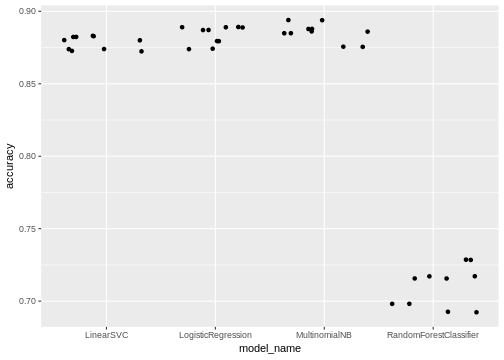

In [32]:
%%R -i cv_df -w 7 -h 5 -u in 

library(ggplot2)
ggplot(cv_df, aes(x= model_name)) +
    geom_jitter(aes(y = accuracy) )



##### DL methods

In [ ]:
# basic block
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=1,
    use_fp16= True,
    bs= 8,
    discriminative=False,
    max_seq_len=128,
    num_labels = 5 # Remember to set the num_labels here
)

from pytorch_transformers import *
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

#DATA = pd.read_csv("uni_frame_fromR.csv", encoding = "ISO-8859-1")





bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels= config.num_labels)

loss_func = nn.CrossEntropyLoss()

def loss_batch_bert(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    #pdb.set_trace()
    out = out[0]
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

# To change the loss_batch function in the loaded fastai module
module_basic_train = sys.modules['fastai.basic_train']
module_basic_train.loss_batch = loss_batch_bert
sys.modules['fastai.basic_train'] = module_basic_train

In [ ]:
train, val = train_test_split(df)
label_cols = ['frame']

databunch = TextDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols= "text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )